# Video Actor Synchroncy and Causality (VASC)
## RAEng: Measuring Responsive Caregiving Project
### Caspar Addyman, 2020
### https://github.com/infantlab/VASC

# Step 3: Analyse the data using scipy statsmodels

This script correlates and compares the timeseries of wireframes for the two figures in the video `["parent", "infant"]`

We start by reloading the saved parquet file containing the multi-index numpy array of all [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) data from all pairs of individuals.



In [1]:
import sys
import os
import json
import math
import scipy.fft
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
%matplotlib inline

import logging
import ipywidgets as widgets  #let's us add buttons and sliders to this page.
from ipycanvas import Canvas

import vasc #a module of our own functions (found in vasc.py in this folder)

#turn on debugging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
%pdb on

Automatic pdb calling has been turned ON


## 2.1 Settings?

Load a json file that tells us where to find our videos and where to save the data. You should create a different settings file for each project. Then you don't need to change any other values in the script for Step 1 or Step 2.

TODO - write a helper to create a settings file


In [2]:
settingsjson = ".\\DrumTutorial\\Drum.Tutorial.settings.json"

try:
    with open(settingsjson) as json_file:
        settings = json.load(json_file)
        print("Existing settings.json found..")
except json.JSONDecodeError:
    logging.exception("Settings file was not valid JSON. (You might be missing a comma or a bracket.)")
except Exception as e:
        emsg = str(e)
        #show the error
        print("Error: ",emsg)
        print("No setting.json file found!\nPlease see Step 0 for instructions")

Existing settings.json found..


In [3]:
anon = settings["flags"]["anon"]
print(f"anon: {anon}")
includeHands = settings["flags"]["includeHands"]
print(f"includeHands: {includeHands}")

anon: False
includeHands: True


In [4]:
# where's the project data folder? (with trailing slash)
projectpath = settings["paths"]["project"]
#where are your video files?
videos_in = settings["paths"]["videos_in"]

# locations of videos and output
videos_out = settings["paths"]["videos_out"]
videos_out_openpose   = settings["paths"]["videos_out_openpose"]
videos_out_timeseries = settings["paths"]["videos_out_timeseries"]
videos_out_analyses   = settings["paths"]["videos_out_analyses"]

print("videos_in: ", videos_in)
print("videos_out: ", videos_out)
print("videos_out_openpose: ", videos_out_openpose)
print("videos_out_timeseries: ", videos_out_timeseries)
print("videos_out_analyses: ", videos_out_analyses)

videos_in:  .\DrumTutorial\videos
videos_out:  .\DrumTutorial\
videos_out_openpose:  .\DrumTutorial\openpose
videos_out_timeseries:  .\DrumTutorial\timeseries
videos_out_analyses:  .\DrumTutorial\analyses


### 3.1 Load the clean data as a DataFrame

Reload the clean data file created in step 2.

In [5]:
#retrieve the list of base names of processed videos.
videosjson = settings["paths"]["videos_out"] + '\\' + settings["filenames"]["clean_json"]
try:
    with open(videosjson) as json_file:
        videos = json.load(json_file)
        print("Existing clean.json found..")
except:
    videos = {}
    print("No clean.json file found, please locate the file or complete Step 2 first.")

Existing clean.json found..


In [6]:
print('reading parquet file(s):')
df = pq.read_table(videos_out_timeseries + '\\' + settings["filenames"]["cleandataparquet"]).to_pandas()

#sort the column names as this helps with indexing
df = df.sort_index(axis = 1)

if includeHands:
    lh = pq.read_table(videos_out_timeseries + '\\' + settings["filenames"]["lefthandparquet"]).to_pandas()
    rh = pq.read_table(videos_out_timeseries + '\\' + settings["filenames"]["righthandparquet"]).to_pandas()
    lh = lh.sort_index(axis = 1)
    rh = rh.sort_index(axis = 1)
    
print(df.head())

reading parquet file(s):
video  1fa339b_04-test-trials                                                 \
person                 infant                                                  
coord                      0        1         2        3        4         5    
0                     603.999  402.094  0.812414  619.638  488.323  0.591055   
1                     605.907  400.237  0.817730  619.558  490.241  0.580483   
2                     607.815  400.268  0.798972  621.568  490.254  0.570408   
3                     605.932  402.122  0.807359  617.672  484.432  0.616228   
4                     605.928  402.124  0.807981  617.688  482.488  0.613706   

video                                        ... b22644a_14-test-trials       \
person                                       ...                 parent        
coord        6        7         8        9   ...                     65   66   
0       478.519  484.430  0.513021  374.709  ...                    0.0  0.0   
1       476.57

## 3.2 Process the data

Before focusing directly on the body part of interest there are several global processing steps we can apply to all the data that we have.


### 3.2.1 Interpolate missing data.

In the dataframe all missing data is represented by a zerro (0.0) value. This is where a body part is not visible or goes off the edge of the frame. We'd like to interpolate these gaps (if possible). So first we find and replace all zeros with `np.nan` (numpy's indcitor for 'not a number'.

Then we use the `interpolate()` method to linearly interpolate the missing data.

In [7]:
df = df.replace(0.0, np.nan)
if includeHands:
    rh = rh.replace(0.0, np.nan)
    lh = lh.replace(0.0, np.nan)

In [ ]:
df.shape

In [8]:
#are we going to use all the data or a subset?
first = 0
last = df.shape[0]

df = df.truncate(before  = first, after = last)

In [9]:
#linear interpolate missing values
df = df.interpolate()
#may still have some NaNs at start so back fill these with first non-zero value
#eg  [NaN, NaN, 3.1, 3.2, ...] -> [3.1, 3.1, 3.1, 3.2, ...]
df = df.fillna(method = 'backfill')

if includeHands:
    rh = rh.interpolate()
    rh = rh.fillna(method = 'backfill')
    lh = lh.interpolate()
    lh = lh.fillna(method = 'backfill')


In [10]:
#take a quick look
print(df.head())
df.shape

video  1fa339b_04-test-trials                                                 \
person                 infant                                                  
coord                      0        1         2        3        4         5    
0                     603.999  402.094  0.812414  619.638  488.323  0.591055   
1                     605.907  400.237  0.817730  619.558  490.241  0.580483   
2                     607.815  400.268  0.798972  621.568  490.254  0.570408   
3                     605.932  402.122  0.807359  617.672  484.432  0.616228   
4                     605.928  402.124  0.807981  617.688  482.488  0.613706   

video                                        ... b22644a_14-test-trials      \
person                                       ...                 parent       
coord        6        7         8        9   ...                     65  66   
0       478.519  484.430  0.513021  374.709  ...                    NaN NaN   
1       476.577  488.301  0.516335  372.761

(956, 4500)

In [11]:
print(lh.head())

video  1fa339b_04-test-trials                                                \
person                 infant                                                 
coord                      0        1         2        3       4         5    
0                     674.631  568.637  0.406643  678.243  531.79  0.410103   
1                     674.631  568.637  0.406643  678.243  531.79  0.410103   
2                     674.631  568.637  0.406643  678.243  531.79  0.410103   
3                     674.631  568.637  0.406643  678.243  531.79  0.410103   
4                     674.631  568.637  0.406643  678.243  531.79  0.410103   

video                                        ... b22644a_14-test-trials  \
person                                       ...                 parent   
coord        6        7         8        9   ...                     53   
0       671.741  497.833  0.225364  634.171  ...               0.517503   
1       671.741  497.833  0.225364  634.171  ...               0.44

### 3.2.2 Mean body part movements

In some cases we might wish to know the avearge location of the head, body, arm or hand. To do this we average together all the points for a given body part and create a new time series for this point. Likewise we may with smooth the movement data by taking a moving average of several frames at once. Or look at the amount of movement by calculating a variance measure. 


We create a dictionary of the subsets of OpenPose coordinates we want to average (per frame) and then call `mean` on the Pandas dataframe. e.g.

```
meanpoints = {
               "headx" : [0, 3, 45, 48, 51, 54],
               "heady" : [1, 4, 46, 49, 52, 55],
               "allx" :  [0, 3, 6, 9, ...],
               "ally" :  [1, 4, 7, 10, ...]
             }
```

Then we call the `vasc.averageCoordinateTimeSeries` function to average across sets of coordinates. For a given set of videos and people. For example

In:
```
videos = "All"
people = "Both"
df2 = vasc.averageCoordinateTimeSeries(df,meanpoints,videos,people)
df2.head
```

Out:
```
person      infant                                          parent
avgs         headx       heady          xs          ys       headx
501     565.996600  369.840600  534.895615  398.482538  471.686200
502     567.231800  369.887600  534.354198  398.706552  471.849400
503     567.228600  370.159600  534.444328  398.678133  471.711600
504     566.912600  369.857000  535.369536  398.551636  472.309400
...            ...         ...         ...         ...         ...
```


In [12]:
meanpoints = {"head" : vasc.headxys,
              "headx": vasc.headx,
              "heady": vasc.heady,
              "arms" : vasc.armsxys,
              "armsx": vasc.armsx,
              "armsy": vasc.armsy,
              "leftarm" : vasc.leftarmxys,
              "leftarmx": vasc.leftarmx,
              "leftarmy": vasc.leftarmy,
              "rightarm" : vasc.rightarmxys,
              "rightarmx": vasc.rightarmx,
              "rightarmy": vasc.rightarmy,
              "all"  : vasc.xys,
              "allx" : vasc.xs,
              "ally" : vasc.ys
             }

vids = "All"
people = ["infant","parent"]

#average across the points in each group (all points of head etc. )
avgdf = vasc.averageCoordinateTimeSeries(df,meanpoints,vids,people)


if includeHands:
    handpoints = {"hand" : vasc.hxys,
           "handx" : vasc.hxs,
           "handy" : vasc.hys}

    avglh = vasc.averageCoordinateTimeSeries(lh,handpoints,vids,people)
    avgrh = vasc.averageCoordinateTimeSeries(rh,handpoints,vids,people)


In [ ]:
#optionally have a look
avgdf.head

### 3.2.3 Combining hand and wrist data

If we have hand data from OpenPose then we can combine this with the body data to get more accurate movements for the left and right hands. Similar to what we did on the step before but combining across multiple dataframes.

We use a weighted sum of the points from elbow, wrist and hand. With wrist weighted more heavily than individual hand points. 


In [13]:
#to calculate the mean, we need to let routine know what points to use. 
#From the arm this the points we want to combine
leftarmpoints = {"hand" : vasc.leftarmxys,
               "handx": vasc.leftarmx,
               "handy": vasc.leftarmy}

rightarmpoints = {"hand" : vasc.rightarmxys,
               "handx": vasc.rightarmx,
               "handy": vasc.rightarmy}

leftwristpoints = {"hand" : vasc.leftwristxys,
               "handx": vasc.leftwristx,
               "handy": vasc.leftwristy}

rightwristpoints = {"hand" : vasc.rightwristxys,
               "handx": vasc.rightwristx,
               "handy": vasc.rightwristy}

handpoints = {"hand" : vasc.hxys,
       "handx" : vasc.hxs,
       "handy" : vasc.hys}


if includeHands:
    rightarmhand = vasc.averageArmHandTimeSeries(df,rh,rightarmpoints,handpoints,vids,people)
    leftarmhand  = vasc.averageArmHandTimeSeries(df,lh,leftarmpoints,handpoints,vids,people)

    #combine hand and wrist data weighting in ratio
    wristtohandweightratio = 21 #since the hand has 21 times more points than wrist but we want both to contribute

    rightwristhand = vasc.averageArmHandTimeSeries(df,rh,rightwristpoints,handpoints,vids,people,wristtohandweightratio)
    leftwristhand  = vasc.averageArmHandTimeSeries(df,lh,leftwristpoints,handpoints,vids,people, wristtohandweightratio)

In [ ]:
rightwristhand

### 3.2.4 Rolling window of movements

One thing we'd like to know is if mothers move in response to infants. The raw time series are probably too noisy to tell us this so instead we can look at few alternatives

1. **Smoothed** - if we average the signal over a short rolling window we smooth out any high-frequency jitter.
2. **Variance** - the variance of movement over a short rolling window. First we apply short (10 frame) rolling window to each coordinate of the body and use the stddev or variance function `std()` or `var()` . Then we take averages as in the step above. However, this time we combine x and y coordinates as this is now a movement index.




In [14]:
win = 10 #10 frames better for rhythm detcion
halfwin = math.floor(win/2)

smoothdf = df.rolling(window = 5).mean()
smoothdf = smoothdf.truncate(before  = first, after = last)

vardf = df.rolling(window = win, min_periods = halfwin).var()
vardf = vardf.truncate(before  = first , after = last) # cut out the empty bits at the start

smoothdf = vasc.averageCoordinateTimeSeries(smoothdf,meanpoints,vids,people)
vardf = vasc.averageCoordinateTimeSeries(vardf,meanpoints,vids,people)

In [15]:
#smooth hand movement data
smoothrightwristhand = rightwristhand.rolling(window = 5).mean()
smoothleftwristhand = leftwristhand.rolling(window = 5).mean()




## Step 3.3 Visualising the data

Let's create a widget to plot some graphs of the data

In [16]:
vidlist = [] #used to fill dropdown options
for vid in videos:
    vidlist.append(vid)

pickvid = widgets.Dropdown(
    options= vidlist,
    value= vidlist[0],
    description='Subject:'
)

series = ["Body"]
if includeHands:
    series = ["Body","Left Hand","Right Hand","Left Arm & Hand","Right Arm & Hand","Left Wrist & Hand (Weighted)","Right Wrist & Hand (Weighted)"]

pickseries = widgets.Dropdown(
    options= series,
    value= series[0],
    description='Series:'
)

    
mainfeatures = []
for f in meanpoints:
    mainfeatures.append(f)

handfeatures = []
for f in handpoints:
    handfeatures.append(f)
    

pickfeature = widgets.Dropdown(
    options= mainfeatures,
    value= mainfeatures[0],
    description='Feature:'
)

linetypes = ["Mean point", "Smoothed Mean (5 frames)","Variance over 2 secs"]
picktype = widgets.Dropdown(
    options= linetypes,
    value= linetypes[0],
    description='Line type:'
)

def pickvid_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        updateAll(True)
        
def pickseries_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        if pickseries.value == series[0]:
            pickfeature.options = mainfeatures
        else:
            pickfeature.options = handfeatures
        updateAll(True)

def pickfeature_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        updateAll(True)

def picktype_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        updateAll(True)

pickvid.observe(pickvid_change, 'value')
pickseries.observe(pickseries_change, 'value')
#pickfeature.observe(pickfeature_change, 'value')
picktype.observe(picktype_change, 'value')
button_update = widgets.Button(description="Redraw")
output = widgets.Output()

txt = widgets.Label(value="Which arm and start/end points do we use?")
leftright = widgets.RadioButtons(
    options=['left', 'right'],
    value='right', # Defaults to 'pineapple'
    description='Arm',
    disabled=False
)
def leftright_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        videos[pickvid.value]["camera1"]["side"] = leftright.value

leftright.observe(leftright_change,'value')

## a couple of sliders to set the start and end points.
startslider = widgets.IntSlider(
    value=0,
    min=0,
    max=videos[pickvid.value]["camera1"]["end"] ,
    step=1,
    description='Start Frame:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='800px')
)
endslider = widgets.IntSlider(
    value=161,
    min=0,
    max=161,
    step=1,
    description='End Frame:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='800px')
)

def slider_change(slider):
    videos[pickvid.value]["camera1"]["start"] = startslider.value
    videos[pickvid.value]["camera1"]["end"] = max(startslider.value,endslider.value) #can't go below start.
    #logging.info (videos[vid]["camera1"])
    updateAll(False)

startslider.observe(slider_change, 'value')
endslider.observe(slider_change, 'value')
    
def drawGraphs(vid, seriestype, feature, linetype):
    """Plot input signals"""
    plt.ion()

#    f,ax=plt.subplots(4,1,figsize=(14,10),sharex=True)
    f,ax=plt.subplots(2,1,figsize=(14,6),sharex=False)
    ax[0].set_title('Infant')
    ax[0].set_xlabel('Frames')
#    ax[1].set_title('Parent')
    ax[1].set_xlabel('Seconds')

    who = ["infant","parent"]

    #what time series (smoothed, etc) are we plotting?
    if linetype == linetypes[0]:
        usedf = avgdf
    elif linetype == linetypes[1]:
        usedf = smoothdf
    else:
        usedf = vardf
    
    #now pick the correct dataseries
    if seriestype == series[0]:
        #nothing to change
        usedf = usedf
    elif seriestype == series[1]:
        usedf = avglh
    elif seriestype == series[2]:
        usedf = avgrh
    elif seriestype == series[3]:
        usedf = leftarmhand
    elif seriestype == series[4]:
        usedf = rightarmhand
    elif seriestype == series[5]:
        usedf = leftwristhand
    elif seriestype == series[6]:
        usedf = rightwristhand    
    else:
        raise ValueError("Unknown series type selected")

    #to select a single column..
    infant = usedf[(vid, people[0], feature)].to_frame()
    parent = usedf[(vid, people[1], feature)].to_frame()
    n  = np.arange(usedf.shape[0])

    #selecting multiple columns slightly messier
    #infant = df3.loc[50:,(vid, part[0], ('head','arms', 'all'))]
    #parent = df3.loc[50:,(vid, part[1], ('head','arms', 'all'))]

    fps = videos[vid]['camera1']['fps']  
    x_time = n / fps #scale by frame per second to get real time
    ax[0].plot(infant)
    #add vertical lines for the start and end points for analysis
    #todo make vertical lines work as times
    starttime = videos[vid]["camera1"]["start"] 
    endtime = videos[vid]["camera1"]["end"]  
    #logging.info(videos[vid]["camera1"])
    ax[0].axvline(x=starttime,c='tab:green')
    ax[0].axvline(x=endtime,c='tab:red')
    ax[1].plot(x_time, infant /fps)
#    ax[1].plot(parent, color='b')
    
#    ax[2].plot(usedf.loc[:,(vid, slice(None), feature)])
#    ax[2].set(xlabel='Time',ylabel='Movement index for parent and infant')

#    if seriestype == series[0]:
#        #calculate the correlations in a shorter rolling window
#        r_window_size = 120
#        rolling_r = usedf[(vid, who[0], feature)].rolling(window=r_window_size, center=True).corr(vardf[(vid, who[1], feature)])
#        rolling_r.plot(ax=ax[3])
#        ax[3].set(xlabel='Time (seconds)',ylabel='Pearson r')
#        ax[3].set_title("Local correlation with rolling window size " + str(r_window_size))

    plt.show()

def updateAll(forceUpdate = False):
    output.clear_output(wait = True)   
    if forceUpdate:
        fps = videos[pickvid.value]['camera1']['fps']  
        startslider.max =  videos[pickvid.value]["camera1"]["frames"]
        endslider.max =  videos[pickvid.value]["camera1"]["frames"]  
        leftright.value = videos[pickvid.value]["camera1"]["side"] 
        logging.debug('forceUpdate')
    with output:
        display(pickvid,pickseries,pickfeature,picktype,txt,leftright,startslider,endslider,button_update)
        drawGraphs(pickvid.value,pickseries.value,pickfeature.value,picktype.value)

#draw everything for first time
updateAll(True)
output

Output()

### Setting at start time across all videos

The next cell loops through all entries in `clean.json` and sets the `start` time the same for all cases. 
Remember that video data is frame by frame and each video could have a different frame rate (`fps`). So we
need to convert time into frames.


In [17]:
starttime = 0 
starttime = 5  #(in seconds)

for vid in videos:
    for cam in videos[vid]:
        videos[vid][cam]["side"] = "right"
        videos[vid][cam]["start"] = int(starttime * videos[vid][cam]["fps"]) #convert time to number of frames
        videos[vid][cam]["end"] = videos[vid][cam]["frames"]

In [18]:
who = ["infant","parent"]
parts = ["head","arms","all"]

## Step 3.4 Read in behavioural coding from Spreadsheet

We load the data from the spreadsheet `LittleDrummers_TutorialManualCoding.xlsx`. 

The worksheet `ManualCoding` contains one row per participant and includes the participant ids, the condition they are in, human rating of whether they drumming, whether this was visible on camera and which hand or hands they used. 

The worksheet `Fourier.All` contains one row per video and includes the participant ids, the trial number (SMT1, 1, 2, 3, 4, SMT2), and for each hand - the peak frequency from the fourier analysis for that video and power at several different target frequencies (400,500,600,700).

We combine these to find group level performance. 


In [81]:
excelfile = videos_out  + "\\LittleDrummers_TutorialManualCoding.xlsx"

manualcoding = pd.read_excel(excelfile, sheet_name = "ManualCoding",  header=[0,1])

fourier = pd.read_excel(excelfile, sheet_name = "Fourier.All.1.0Hzcuttoff",  header=[0,1])

nchildren = len(manualcoding)

print(f"ManualCoding sheet contains {nchildren} rows.")

print(f"Fourier data sheet contains {len(fourier)} rows.")

ManualCoding sheet contains 5 rows.
Fourier data sheet contains 30 rows.


## Step 3.4.1 Find trial info

For each trail we need to know the target inter stimulus interval (ISI) for each trial. For children in condition 0 the trial order was (SMT1, 400, 600, 500, 700, SMT2), in condition 1 the order was (SMT1, 700,500,600,400, SMT2). We create few helper functions to keep track of this and read information from the manual coding spreadsheet. 

In [45]:
#Create a look up arrays to find out the ISI for each trial + condition
orders =  [[400, 600, 500, 700],[700,500,600,400]]
#And a data structure to do the reverse find Trial from targetISI and condition 
trialNames = {400: {0:"Trial1", 1:"Trial4"},
          500: {0:"Trial3", 1:"Trial2"},
          600: {0:"Trial2", 1:"Trial3"},
          700: {0:"Trial4", 1:"Trial1"},
          "SMT1": {0:"SMT1", 1:"SMT1"}, #SMT trials not affected by condition
          "SMT2": {0:"SMT2", 1:"SMT2"}
         }
trialTypes = {"Trial1": {0:400, 1:700},
              "Trial2": {0:600, 1:500},
              "Trial3": {0:500, 1:600},
              "Trial4": {0:700, 1:400},
              "SMT1": {0:"SMT1", 1:"SMT1"}, #SMT trials not affected by condition
              "SMT2": {0:"SMT2", 1:"SMT2"}
         }

def vidStringtoTrialName(vidString):
# function to work out trial type from filename
    lookitStep = int(vidString[8:10])
    if lookitStep == 4:
        trialName = "SMT1"
    elif lookitStep == 14:
        trialName  = "SMT2"
    else:
        idx = (lookitStep -6) // 2
        trialName = "Trial" + str(1+idx)
    return trialName

In [38]:
#see if it works as expected
print(trialNames[500][0])
print(trialTypes["Trial4"][1])
vidstring = "1fa339b_12-test-trials"
print(vidStringtoTrialName(vidstring))

Trial3
400
Trial4


In [46]:
def TrialInfo(manualcodingsheet, fourier, vidString):
    # uses info in our manual coding spreadsheet to determine if
    # 1. this is a valid trial (e.g. not an aborted recording)
    # 2. then if hands are in view and if there is drumming with left or right hand
    
    
    trial = lambda: None   #Standard hack to create an object with dynamic properties
    trial.error = ""
    
    trial.ID = vidString[0:7]
    #can we find this child?
    child = manualcoding[manualcoding["ChildID","ChildID"] == trial.ID]
    if len(child) != 1:
        trial.error = "There were " + str(len(child)) + " entries found for ID = " + trial.ID + " (Expecting 1.)"
        return trial
        

    #work out trial name (SMT1, Trial1, etc from video name)
    trial.name = vidStringtoTrialName(vidString)
    

    #get manual coding data for this id
    coded = fourier[(fourier["ChildID","ChildID"]  == trial.ID) & (fourier["TrialID","TrialID"] == trial.name)]
    if len(coded) != 1:
        trial.error = "There were " + str(len(coded)) + " fourier entries found for ID = " + trial.ID + " (Expecting 1.)"
        return trial
    else:
        fidx = coded.index[0]
        fouriervideo = coded.at[fidx, ("VideoName","VideoName")]
        if vidString != fouriervideo:
            trial.error = "Video " + vidString + " is not used for " + trial.name + " Expecting " + fouriervideo 
            return trial
        
    rowidx = child.index[0]
    
    #trial.ID = child.at[rowidx, ("ChildID","ChildID")]
    trial.respcompleted = child.at[rowidx, ("response_completed","response_completed")]
    trial.withdrawn = child.at[rowidx, ("response_withdrawn","response_withdrawn")]
    trial.condition = child.at[rowidx, ("response_condition","response_condition")]
    
    
    trial.ISI = trialTypes[trial.name][trial.condition]
    if isinstance(trial.ISI, (str)): #an SMT trial
        trial.desc = trial.name 
        trial.freq = ""
        trial.filename = trial.name
    else:
        trial.desc = trial.name + " " + "Target ISI: " + str(trial.ISI) + "ms"
        trial.freq = "Target freq: {:.2f} Hz".format(1000/trial.ISI)
        trial.filename = trial.name + "." + str(trial.ISI) + "ms"
    
    trial.cleaned = child.at[rowidx, (trial.name,"Data cleaned")]
    trial.attempted = child.at[rowidx, (trial.name,"Trial Attempted")]
    trial.respcompleted = child.at[rowidx, (trial.name,"Trial Complete")]
    trial.inView = child.at[rowidx, (trial.name,"In View")]
    trial.infantDrum = child.at[rowidx, (trial.name,"Infant Drum")]
    trial.rightHand = child.at[rowidx, (trial.name,"Right Hand")]
    trial.leftHand = child.at[rowidx, (trial.name,"Left Hand")]

    return trial

In [47]:
def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.3, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")

In [48]:
trial = TrialInfo(manualcoding, fourier,vidstring)
print(trial.ID)
print(trial.error)
print(trial.respcompleted)
print(trial.inView )


if trial.respcompleted and not trial.withdrawn and trial.cleaned: #is this valid data?
    if trial.attempted and trial.inView and trial.infantDrum: #was there any (visible) drumming?
        print(trial.leftHand,trial.rightHand)
    else:
         print("no drumming")
else:
    print("Not a valid trial")

1fa339b

1
1
0 1


In [49]:
#number of participants, average age
ps = manualcoding[manualcoding["include","include"] == True]
excl =manualcoding[manualcoding["include","include"] == False]

age = ps["child_age_rounded","child_age_rounded"]
print("Mean age {:.1f}, +/- {:.1f}, min {:.1f} max {:.1f}".format(age.mean(), age.std(),age.min(),age.max()))

gender = np.unique(ps["child_gender","child_gender"], return_counts=True)

print(len(ps))
print(gender)


Mean age 774.0, +/- 235.6, min 450.0 max 1110.0
5
(array(['f', 'm', 'na', 'o'], dtype=object), array([2, 1, 1, 1], dtype=int64))


## 3.5 Finding fundamental frequency with FFT


A good guide can be found here https://realpython.com/python-scipy-fft/

Filtering explained here https://scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html


In this first block of code we want to see the freequency power at each target ISI/frequency and the absolute peak 

ID: 1fa339b SMT1 No visible drumming
ID: 1fa339b Trial1 Target ISI: 400ms Target freq: 2.50 Hz


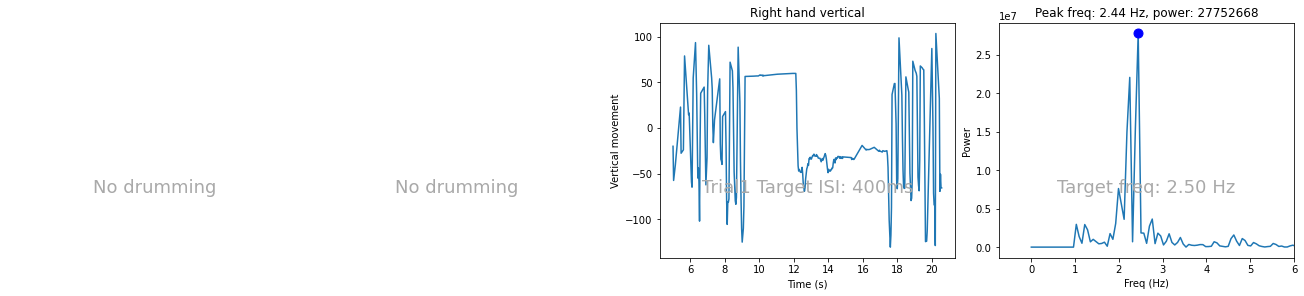

ID: 1fa339b Trial2 Target ISI: 600ms Target freq: 1.67 Hz


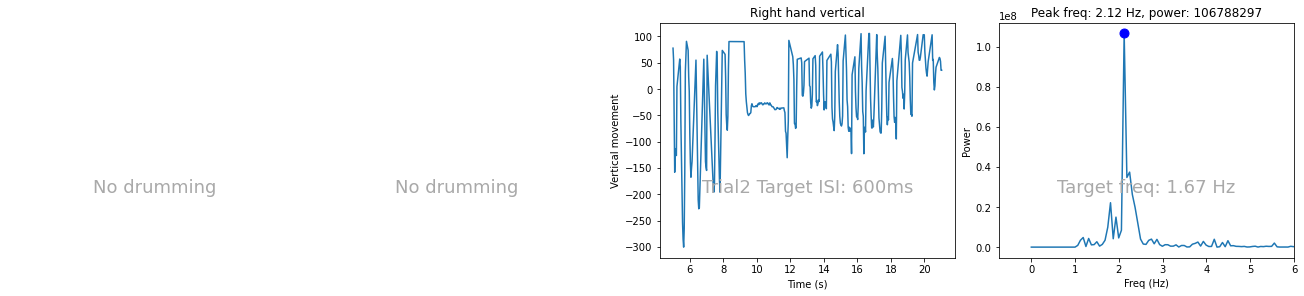

ID: 1fa339b Trial3 Target ISI: 500ms Target freq: 2.00 Hz


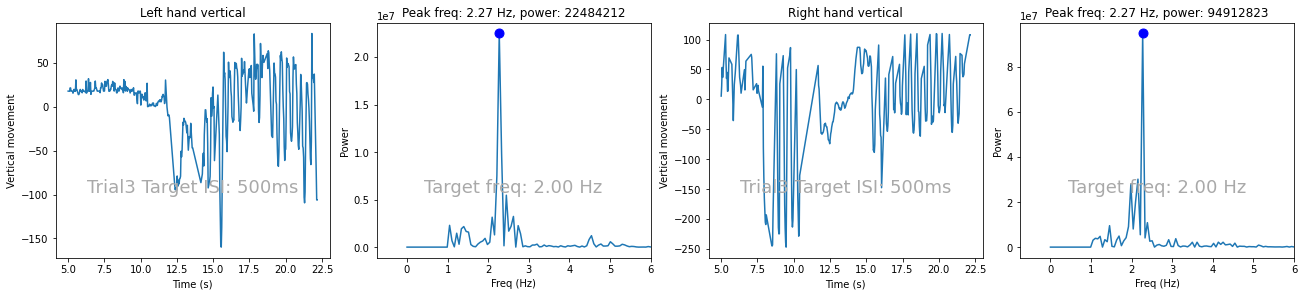

ID: 1fa339b Trial4 Target ISI: 700ms Target freq: 1.43 Hz


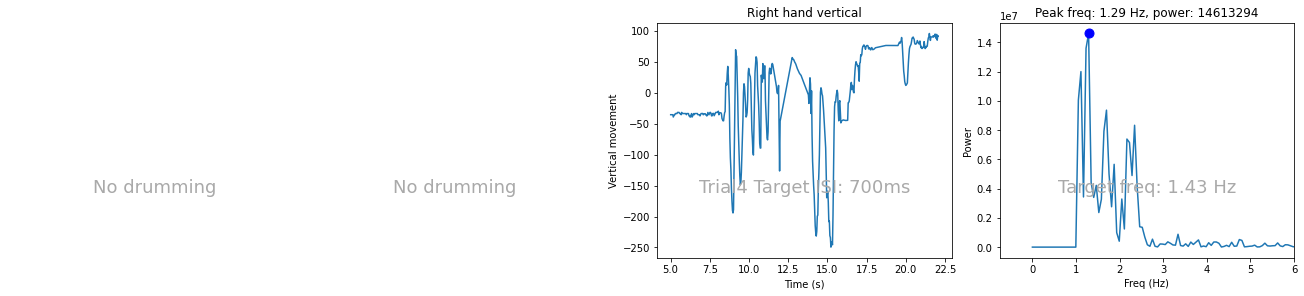

ID: 1fa339b SMT2 


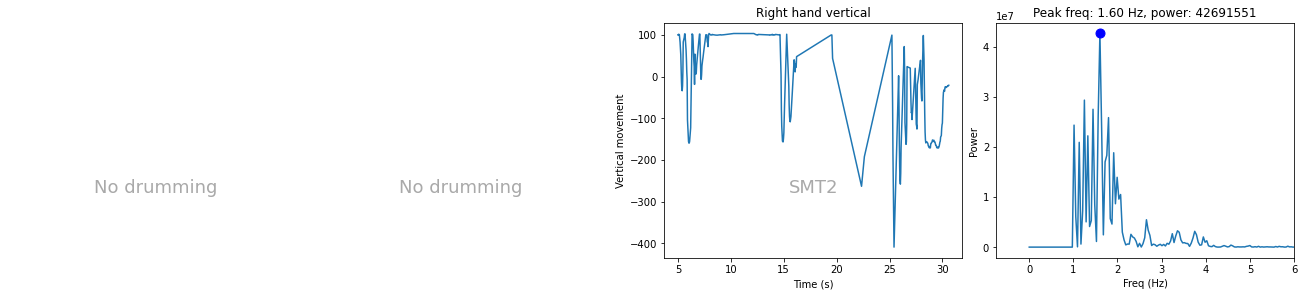

ID: 768fa72 SMT1 


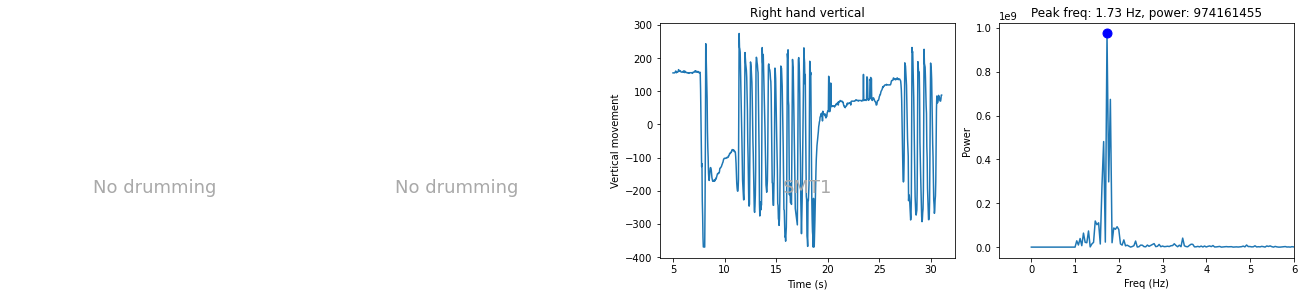

ID: 768fa72 Trial1 Target ISI: 700ms Target freq: 1.43 Hz


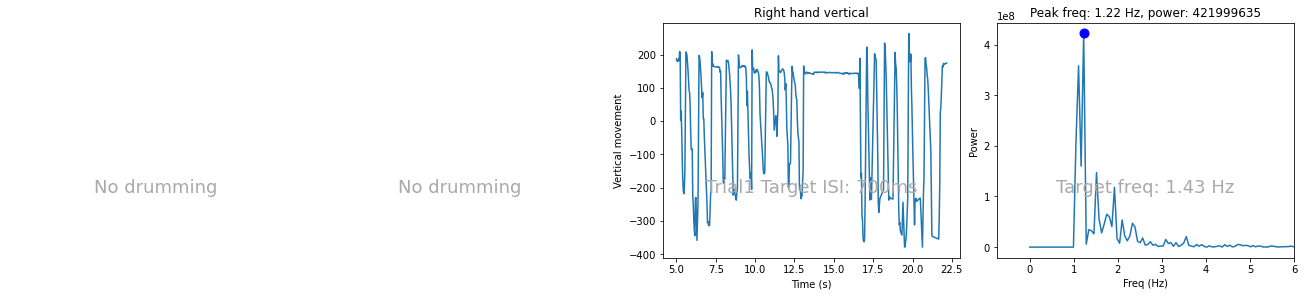

ID: 768fa72 Trial2 Target ISI: 500ms Target freq: 2.00 Hz


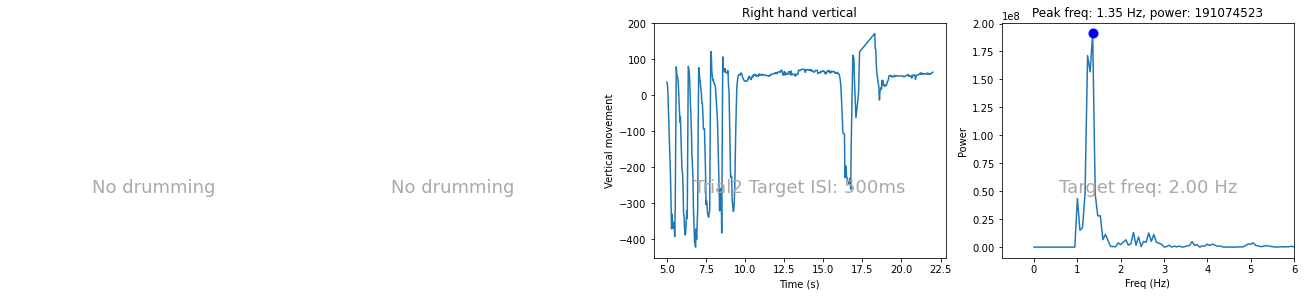

ID: 768fa72 Trial3 Target ISI: 600ms Target freq: 1.67 Hz


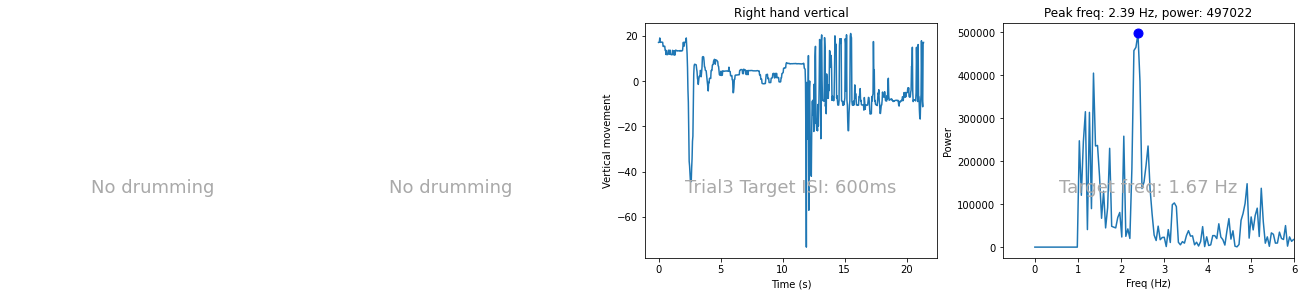

ID: 768fa72 Trial4 Target ISI: 400ms No visible drumming
ID: 768fa72 SMT2 


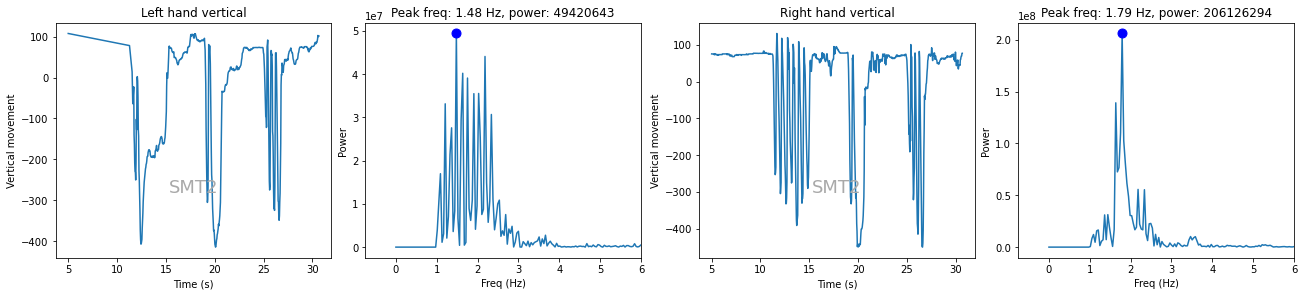

ID: b22644a SMT1 


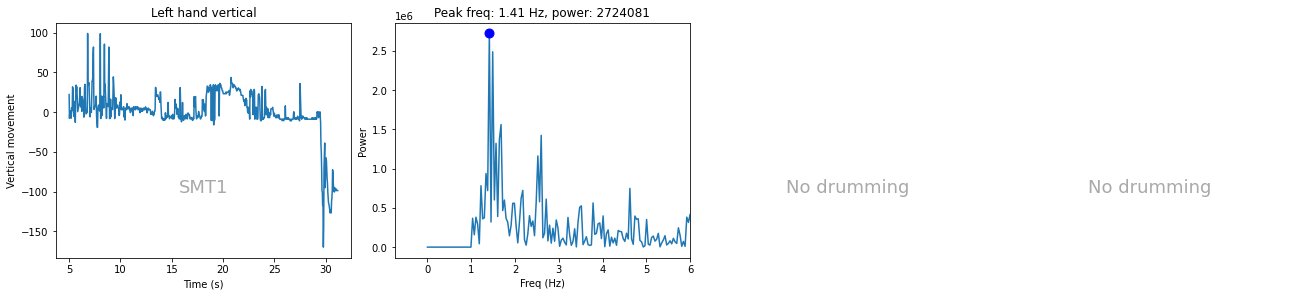

ID: b22644a Trial1 Target ISI: 400ms Target freq: 2.50 Hz


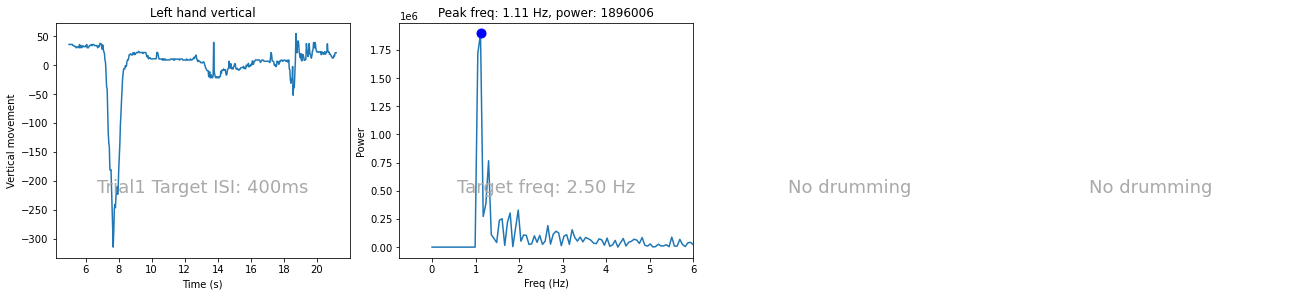

ID: b22644a Trial2 Target ISI: 600ms Target freq: 1.67 Hz


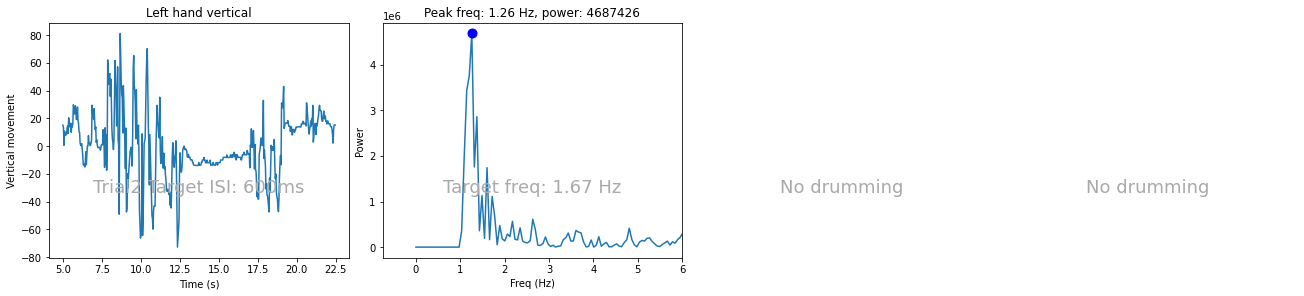

ID: b22644a Trial3 Target ISI: 500ms Target freq: 2.00 Hz


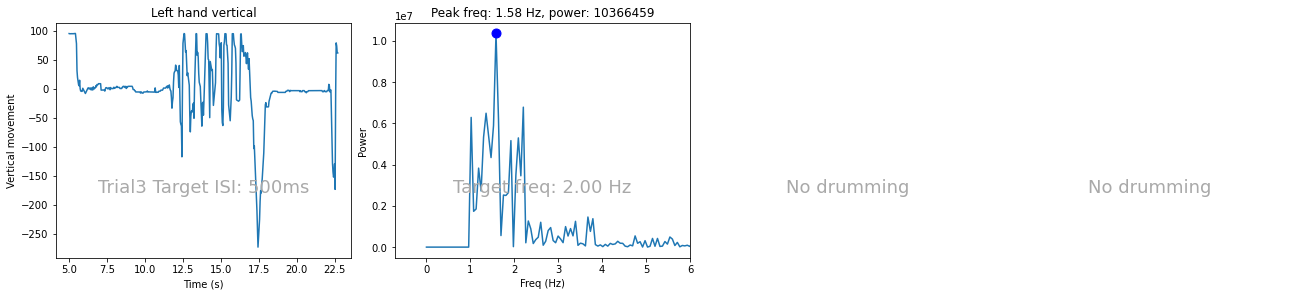

ID: b22644a Trial4 Target ISI: 700ms Target freq: 1.43 Hz


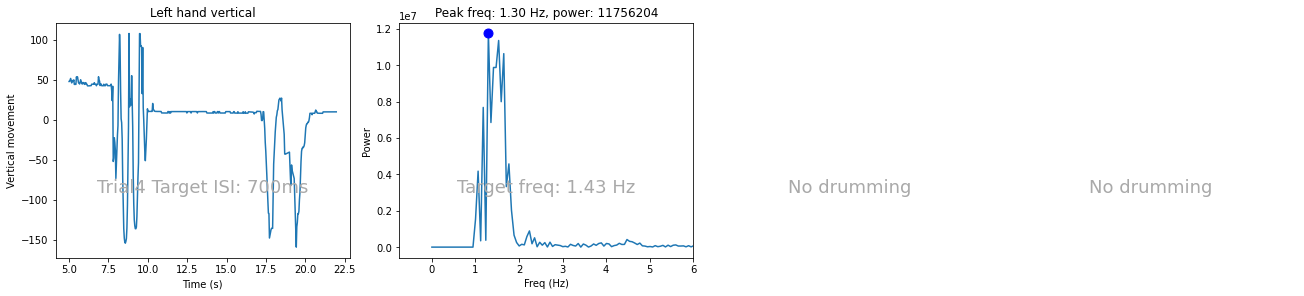

ID: b22644a SMT2 


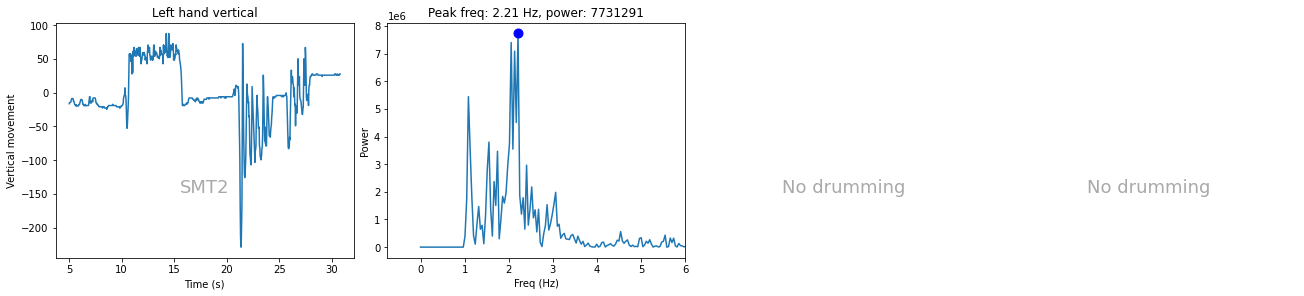

ID: CasparA SMT1 


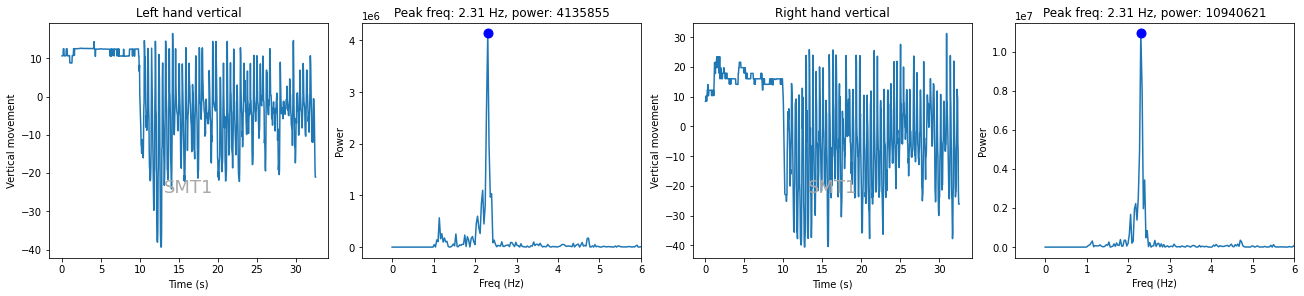

ID: CasparA Trial1 Target ISI: 700ms Target freq: 1.43 Hz


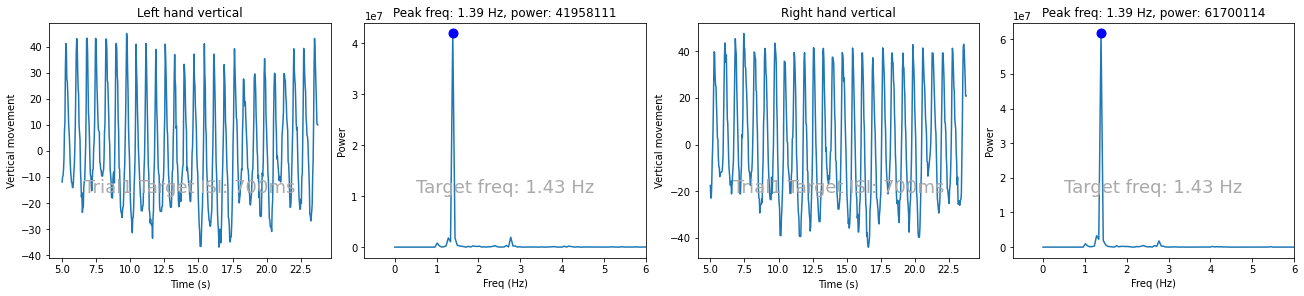

ID: CasparA Trial2 Target ISI: 500ms Target freq: 2.00 Hz


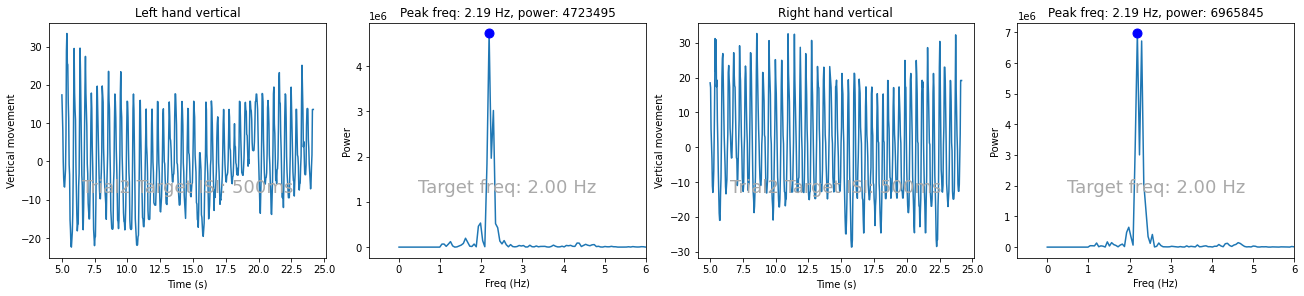

ID: CasparA Trial3 Target ISI: 600ms Target freq: 1.67 Hz


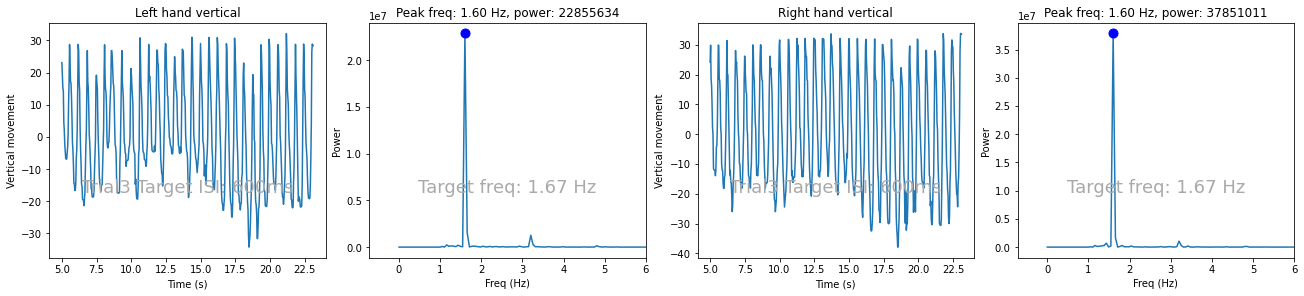

ID: CasparA Trial4 Target ISI: 400ms Target freq: 2.50 Hz


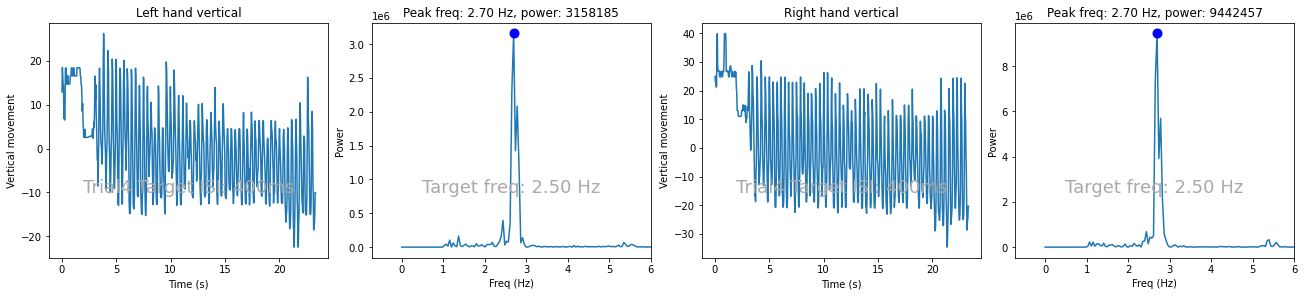

ID: CasparA SMT2 


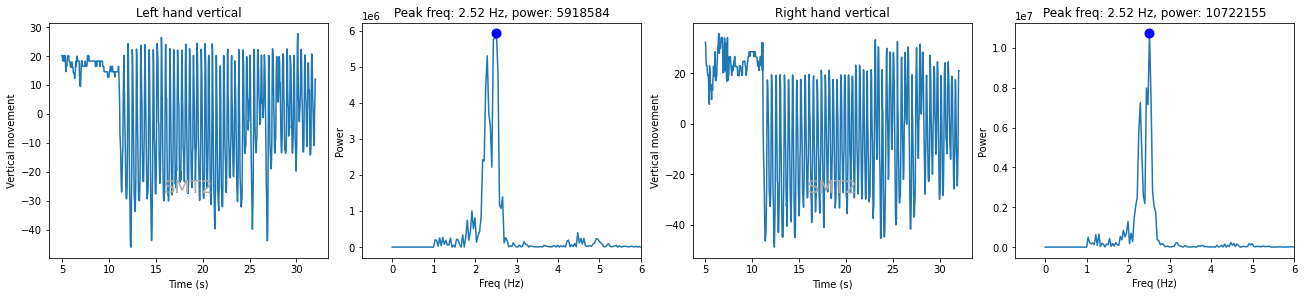

ID: SineadR SMT1 


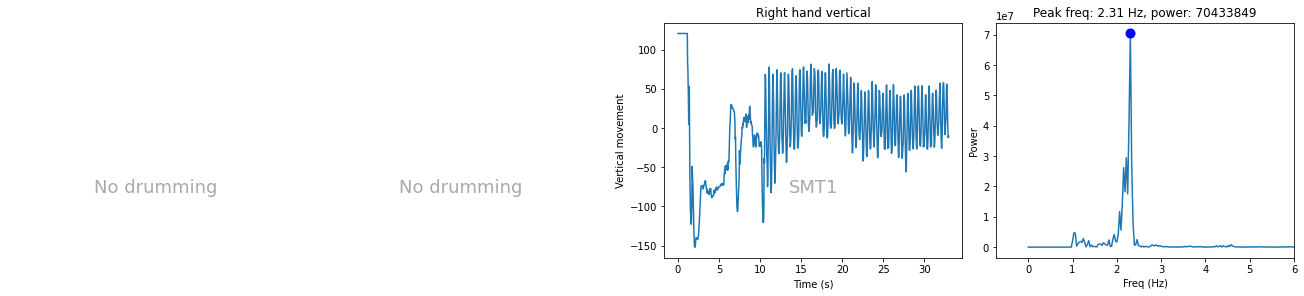

ID: SineadR Trial1 Target ISI: 700ms Target freq: 1.43 Hz


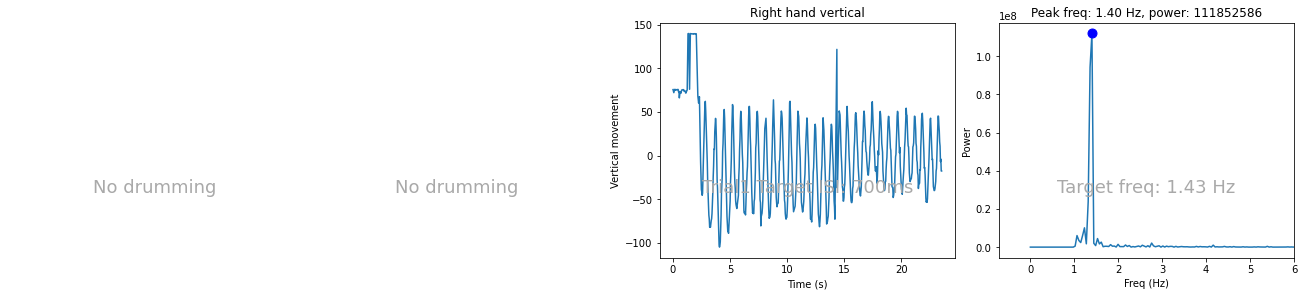

ID: SineadR Trial2 Target ISI: 500ms Target freq: 2.00 Hz


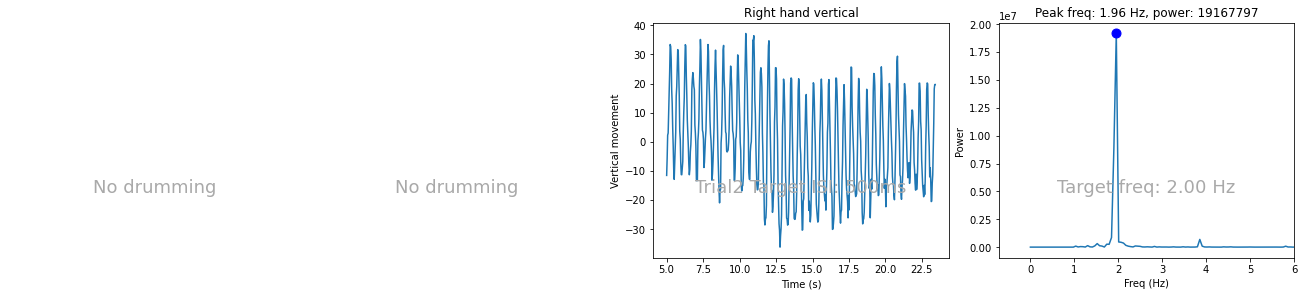

ID: SineadR Trial3 Target ISI: 600ms Target freq: 1.67 Hz


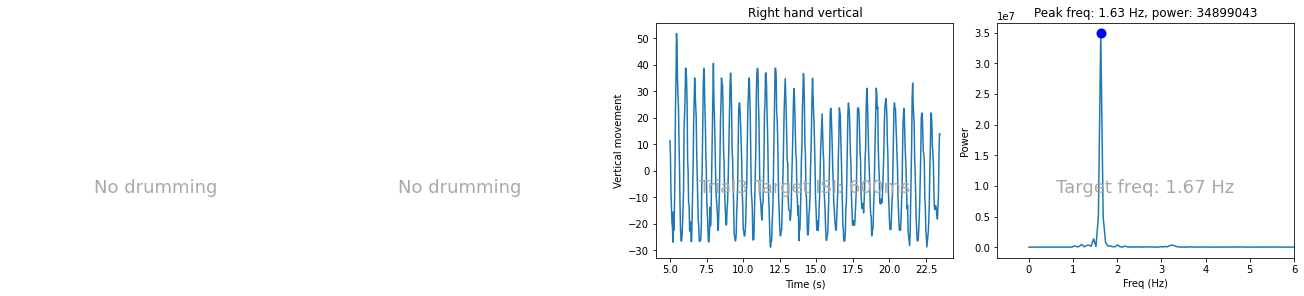

ID: SineadR Trial4 Target ISI: 400ms Target freq: 2.50 Hz


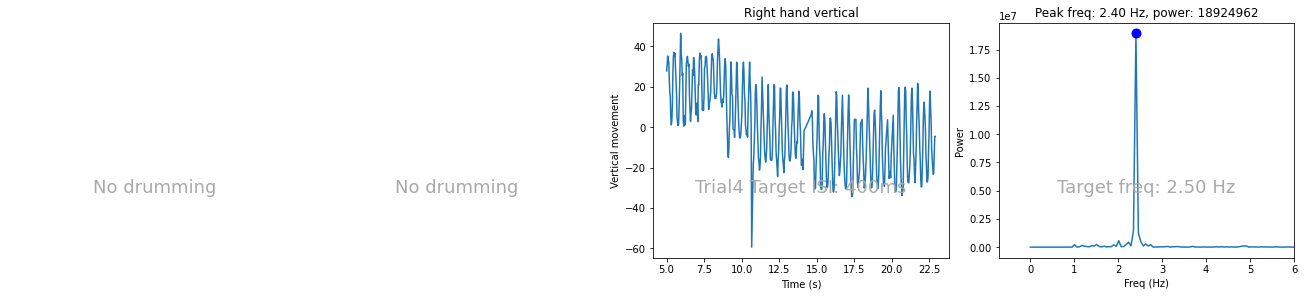

ID: SineadR SMT2 


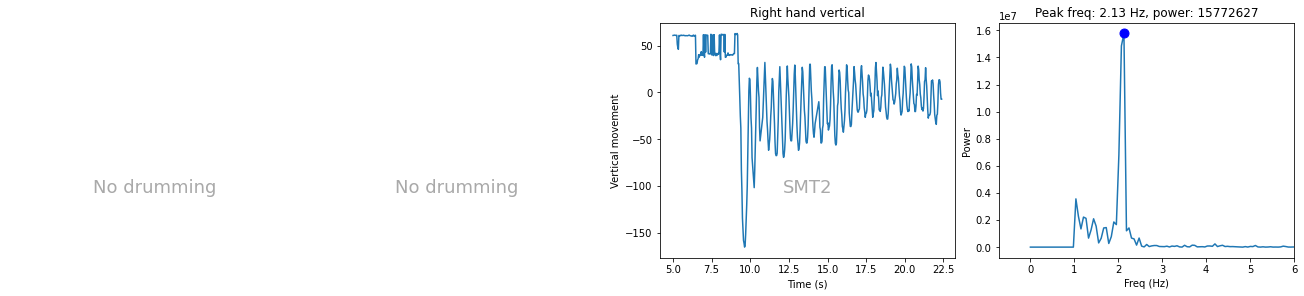

In [83]:
plotgraphs = True
savegraphs = False #save figs to png rather than on screen
savedata = True


leftdf = leftwristhand
rightdf = rightwristhand

bodypart = 'handy'

failarray = [math.nan, math.nan, math.nan, math.nan, math.nan, math.nan]  #empty array if we fail to fit function

resultRight = pd.DataFrame(columns = ("peakfreq","peakpower", "400","500","600","700","fps","message"), index = videos)
resultLeft = pd.DataFrame(columns = ("peakfreq","peakpower", "400","500","600","700","fps","message"), index = videos)

halfbinwidth = 4
targetFreqs = [1000/400, 1000/500, 1000/600, 1000/700]
#freqResults =pd.DataFrame(columns = ("SMT450","ISI400","ISI500","ISI600","ISI700"))

#what is the lower end cutoff in Hertz? 
#note - since each video has a different speed (diff fps) we need to convert/this value for each vid.
lowendcutoffinHz = 1.0


for vid in videos:
    trial = TrialInfo(manualcoding,fourier, vid)
    if len(trial.error) > 0:
        print(vid, "No data: " + trial.error)
    elif not trial.respcompleted or trial.withdrawn or not trial.cleaned: #is this valid data?
        print("ID: " + trial.ID, trial.desc, "No clean data" )
    elif not trial.attempted or not trial.inView or not trial.infantDrum: 
        print("ID: " + trial.ID, trial.desc, "No visible drumming")
    else: 
        print("ID: " + trial.ID, trial.desc, trial.freq)
        #retrieve the raw data for this video
        frames = videos[vid]['camera1']['frames']    #how many frames?
        start = videos[vid][cam]["start"] 
        end = videos[vid][cam]["end"]
        fps = videos[vid]['camera1']['fps']          #how many frames per second?
        #sampleframes = end - start

        if plotgraphs:
            fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(18, 4), constrained_layout=True)

        for side in [0, 1]: #0 = left, 1 = right
            if side == 0:
                whichdf = leftdf
                havedata = trial.leftHand
                title = "Left"
            else:
                whichdf = rightdf
                havedata = trial.rightHand
                title = "Right"

            if not havedata:
                annotate_axes(axs[2*side], "No drumming")
                annotate_axes(axs[2*side + 1], "No drumming")
                axs[2*side].set_axis_off()
                axs[2*side + 1].set_axis_off()
            else:
                armmov = whichdf[(vid, people[0], bodypart)]  #get the averaged data
                y_data = armmov.truncate(before = start, after = end).to_numpy()  #convert to numpy array

                #we are just interested in the periodic elements (not absolute value above zero) so substract the mean
                y_normed = np.subtract(y_data,np.average(y_data))

                x_data = np.linspace(start,start+len(y_data),len(y_data))      #x axis
                x_time = x_data / fps                        #x axis in units of time (seconds)

                try:
                    yfft = scipy.fft.rfft(y_normed)
                    power = np.abs(yfft)**2
                    xfreq = scipy.fft.rfftfreq(x_data.size, 1 / fps)

                    #frequency cutoff at the lower end 
                    #as these frequencies are not relevant  
                    power[np.abs(xfreq) < lowendcutoffinHz] = 0

                    #let's find the maximum frequency.
                    #we hope this is infant's repetitive movement
                    mY = np.abs(power) # Find magnitude
                    peakY = np.max(mY) # Find max peak
                    locY = np.argmax(mY) # Find its location
                    frqY = xfreq[locY] # Get the actual frequency value
                    #print(frqY)

                    #let's find the power in a given frequency bucket corresponding to target freq
                    buckets = [0,0,0,0]
                    powers = [0,0,0,0]
                    for p in range(4):
                        #find the nearest value in our list to
                        bucket =  np.argmax(xfreq>targetFreqs[p])
                        buckets[p] = xfreq[bucket]
                        powers[p] = sum(mY[bucket-halfbinwidth:bucket+halfbinwidth])

                    #print("buckets:", buckets)
                    #print("powers: ",powers)

                    if plotgraphs:

                        #plot the vertical movement of this hand
 
                        axs[2*side].plot(x_time, y_normed)
                        axs[2*side].title.set_text(title + " hand vertical")
                        axs[2*side].set_xlabel('Time (s)')
                        axs[2*side].set_ylabel('Vertical movement')

                        #now plot the Fourier power 
                        axs[2*side + 1].plot(xfreq, power)
                        # New - Plot the max point
                        axs[2*side + 1].plot(frqY, peakY, 'b.', markersize=18)
                        # Rest of the code is the same
                        axs[2*side + 1].set_xlabel('Freq (Hz)')
                        axs[2*side + 1].set_ylabel('Power')
                        axs[2*side + 1].set_xlim(right=6)
                        #make title reflecting peak information
                        axs[2*side + 1].title.set_text('Peak freq: {:.2f} Hz, power: {:.0f}'.format(frqY,peakY))
                        
                        annotate_axes(axs[2*side], trial.desc)
                        annotate_axes(axs[2*side + 1], trial.freq)


                    if savedata:
                        #save all values to dataframe
                        vals = []
                        vals.append(frqY)  #max frequency
                        vals.append(peakY)  #max power
                        vals.extend(powers)
                        vals.append(fps)
                        vals.append("Success")
                        #print("this row: ", vals)
                        if side == 0:
                            resultLeft.loc[vid] = vals
                        else:
                            resultRight.loc[vid] = vals
                        

                except Exception as e:
                    #emsg = "".join(str(e)) #error message string hack :(
                    emsg = str(e)
                    #show the error
                    print(vid, " Error: ",emsg)
                    if savedata:
                        #record error in our results array
                        vals = failarray.copy()
                        vals.append(fps)
                        vals.append(emsg)
                        print(vals)
                        results.loc[vid] = vals
            
        if savegraphs:
            plt.savefig(f"{videos_out}\\plots\\{trial.ID}.{trial.filename}.png")
            plt.close()
        else:
            plt.show()
            plt.close()









In [ ]:
#save the fitted parameters.
resultLeft.to_excel(videos_out  + "\\LeftHand.FixedBinFreq.xlsx")
resultRight.to_excel(videos_out  + "\\RightHand.FixedBinFreq.xlsx")

In [88]:
def plotHistograms(targetISI,fs):
    # the histogram of the data
    binList = np.linspace(1.00,3.6,14)
    n, bins, patches = plt.hist(fs, bins = binList , density=False, facecolor='g', alpha=0.75)

    plt.xlabel('Frequency bins (Hz)')
    plt.ylabel('Count')
    if isinstance(targetISI, (str)):
        plt.title('Histogram of Drumming Frequencies for ' + targetISI)
    else:
        plt.title('Histogram of Drumming Frequencies for target {:.2f} Hz'.format(1000/targetISI))

    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.xlim(40, 160)
    #plt.ylim(0, 0.03)
    plt.grid(True)
    plt.show()

4


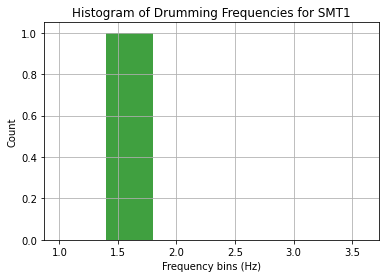

5


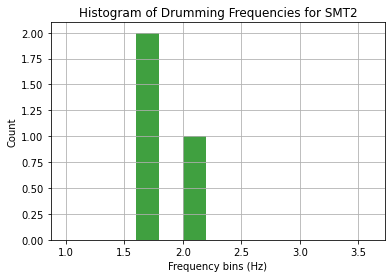

4


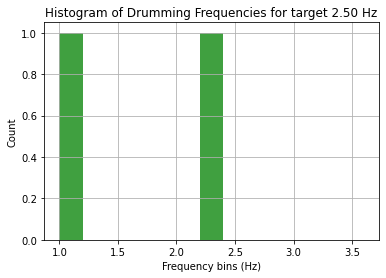

5


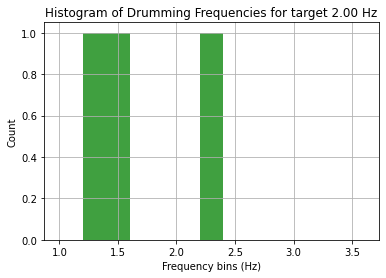

5


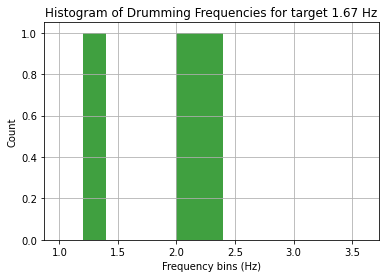

5


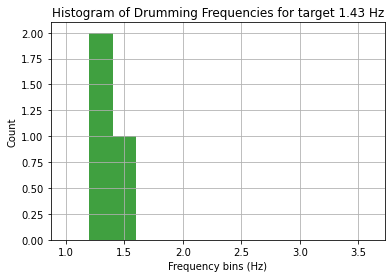

In [89]:

for targetISI in ["SMT1","SMT2",400,500,600,700]:
    fs = []
    for vid in videos:
        trial = TrialInfo(manualcoding,fourier, vid)
        if len(trial.error) == 0:
            if trial.respcompleted and not trial.withdrawn and trial.cleaned: #is this valid data?
                if trial.attempted and trial.inView and trial.infantDrum: #was there any (visible) drumming?
                    if trial.ISI == targetISI:
                        #select all the fourier data for this child
                        freqpower = fourier[fourier['ChildID','ChildID'] == trial.ID]
                        if trial.leftHand and trial.rightHand:
                            l = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Left","peakpower"])
                            r = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Right","peakpower"])
                            #select the hand with greatest power
                            side = ("Right" if r > l else "Left")
                            f = float(freqpower[freqpower['TrialID','TrialID'] == trial.name][side,"peakfreq"])
                        elif trial.rightHand:
                            f = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Right","peakfreq"])
                        elif trial.leftHand:
                            f = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Left","peakfreq"])
                        else:
                            f = None
                        #print(trial.ID, trial.name, trial.ISI, trial.leftHand, trial.rightHand,f)
                        #print(f)
                        fs.append(f)

    print(len(fs))
    plotHistograms(targetISI,fs)

In [90]:
def AbsolutePowerGraph(targetISI,powerinband):
    means3 = powerinband.agg([np.mean, np.std])
    means3.T.plot(kind = "bar", y = "mean", legend = False,
                title = "Average power per ISI freqs for target ISI = " + targetISI + "ms", yerr = "std")
    
def RelativePowerGraph(targetISI,powerinband):
    normalise = powerinband.iloc[:, 1:5]
    normalise = normalise.div(normalise.sum(axis=1), axis=0)

    means3 = normalise.agg([np.mean, np.std])
    means3.T.plot(kind = "bar", y = "mean", legend = False,
                title = "Relative power per ISI freqs for target ISI = " + targetISI + "ms", yerr = "std")

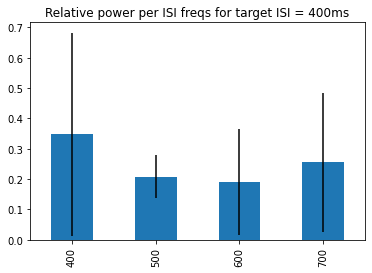

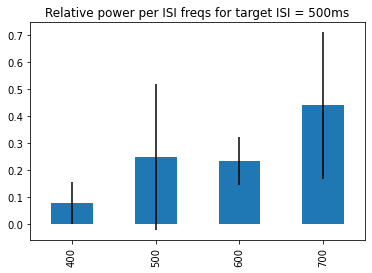

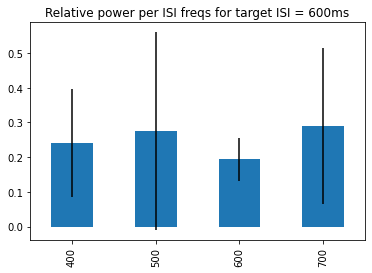

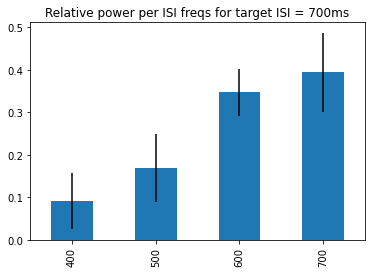

In [91]:

for targetISI in [400,500,600,700]:
    
    #data structure to store power found in target bands
    powerinband = pd.DataFrame(columns = ("ID", "400","500","600","700"))
    
    for vid in videos:
        trial = TrialInfo(manualcoding,fourier, vid)
        onerow = {}
        if len(trial.error) == 0:
            if trial.respcompleted and not trial.withdrawn and trial.cleaned: #is this valid data?
                if trial.attempted and trial.inView and trial.infantDrum: #was there any (visible) drumming?
                    if trial.ISI == targetISI:    
                        #select all the fourier data for this child
                        freqpower = fourier[fourier['ChildID','ChildID'] == trial.ID]

                        for frequencyBand in ["400","500","600","700"]:
                            if trial.leftHand and trial.rightHand:
                                l = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Left",frequencyBand])
                                r = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Right",frequencyBand])
                                p = max(l,r)
                            elif trial.rightHand:
                                p = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Right",frequencyBand])
                            elif trial.leftHand:
                                p = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Left",frequencyBand])
                            else:
                                p = None
                            onerow[frequencyBand] = p
                        
                        #print(onerow)
                        powerinband = powerinband.append(onerow, ignore_index=True)
    
    RelativePowerGraph(str(targetISI),powerinband)
    #AbsolutePowerGraph(str(targetISI),powerinband)


### Step 3.6 Child drumming accuracy

For each child we want to compare the drumming they did to the target shown on the screen. So collect together all the (non-SMT) trials in which there was drumming and show the peak Freq, ISI for each hand (that drums). The 'best' hand is defined to be the hand which the greater power at the peak frequency.

In [92]:
#data structure to store power found in target bands
drummingaccuracy = pd.DataFrame(columns = ("ChildID", "Trial", "TargetISI","TargetHz", "BestISI","BestHz","LeftISI","LeftHz","RightISI","RightHz"))

for vid in videos:
    trial = TrialInfo(manualcoding,fourier, vid)
    onerow = {}
    if len(trial.error) == 0:
        if trial.respcompleted and not trial.withdrawn and trial.cleaned: #is this valid data?
            if trial.attempted and trial.inView and trial.infantDrum: #was there any (visible) drumming?
                onerow["ChildID"] = trial.ID
                onerow["Trial"] = trial.name
                onerow["TargetISI"] = trial.ISI
                if isinstance(trial.ISI, (str)):
                    onerow["TargetHz"] = None
                else:
                    onerow["TargetHz"] = 1000/trial.ISI
                
                #select all the fourier data for this child
                freqpower = fourier[fourier['ChildID','ChildID'] == trial.ID]

                #there's probably a more succint way to do this :-p
                if trial.leftHand and trial.rightHand:
                    onerow["LeftHz"] = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Left","peakfreq"])
                    onerow["LeftISI"] = 1000 / onerow["LeftHz"] 
                    onerow["RightHz"] = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Right","peakfreq"])
                    onerow["RightISI"] = 1000 / onerow["RightHz"] 
                    onerow["BestHz"] = max(onerow["LeftHz"] ,onerow["RightHz"] )
                    onerow["BestISI"] = 1000 / onerow["BestHz"] 
                elif trial.rightHand:                    
                    onerow["LeftHz"] = None
                    onerow["LeftISI"] = None
                    onerow["RightHz"] = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Right","peakfreq"])
                    onerow["RightISI"] = 1000 / onerow["RightHz"] 
                    onerow["BestHz"] = onerow["RightHz"] 
                    onerow["BestISI"] = 1000 / onerow["BestHz"] 
                elif trial.leftHand:
                    onerow["LeftHz"] = float(freqpower[freqpower['TrialID','TrialID'] == trial.name]["Left","peakfreq"])
                    onerow["LeftISI"] = 1000 / onerow["LeftHz"] 
                    onerow["RightHz"] = None
                    onerow["RightISI"] = None
                    onerow["BestHz"] = onerow["LeftHz"]
                    onerow["BestISI"] = 1000 / onerow["BestHz"] 
                else:
                    print(f"In theory this can't happen. No left or right drumming data for {vid}")
                
                #print(onerow)
                drummingaccuracy = drummingaccuracy.append(onerow, ignore_index=True)

In [ ]:
    
drummingaccuracy.to_excel(videos_out  + "\\DrummingAccuracy.xlsx")